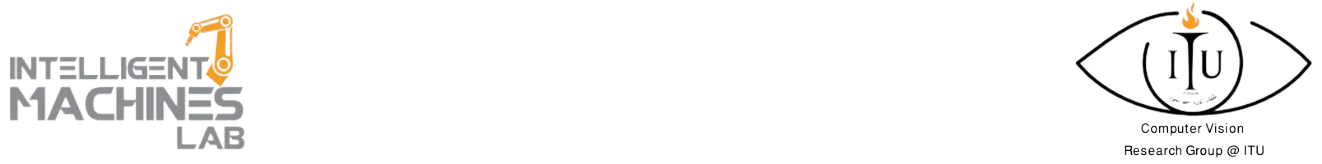

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Rizwan Ahmad`

Reg No: `MSCS-23002`

Github Link: `https://github.com/raze-b/genAI_2024_assignment_2.git`

In [234]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torchvision import datasets, transforms
import torch.optim as optim

from collections import OrderedDict
import numpy as np

# Model Definition

In [235]:
def weights_init(weights_shape:tuple, input_size:int, layer_num:int):
    # TODO: Use He Initialization and use this function to initialize the weights of the model
    weights = torch.randn(weights_shape)*np.sqrt(2/(input_size**layer_num))
    # print(f'weights_init - weights.shape:{weights.shape}')
    return torch.nn.Parameter(weights)

class CNN_VAE(nn.Module):
    def __init__(self, input_channels:int=1, h_dims:list=[32, 64], latent_dims:int=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        # TODO: Initialize the encoder Layers
        seq_1 = OrderedDict()
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        in_ch = input_channels
        for index, output_channels in enumerate(h_dims):
            seq_1['conv_layer_'+str(index)] = nn.Conv2d(in_ch, output_channels, kernel_size=3, stride=2, padding=1)
            seq_1['RELU_e_'+str(index)] = nn.ReLU()
            in_ch = output_channels

        # The output of the encoder will be flattened to a single vector
        seq_1['flatten'] = nn.Flatten()
        print(seq_1)
        self.encoder = nn.Sequential(seq_1)

        # TODO: Initialize the FC layers to output the mean and log variance
        self.fc_mean = nn.Linear(in_features=7*7*64, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=7*7*64, out_features=latent_dims)

        # TODO: Initialize the decoder layers
        seq_2 = OrderedDict()
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        temp_dims = list(h_dims)
        temp_dims.sort(reverse=True)
        temp_dims.append(input_channels)
        self.decoder_fc_layer = nn.Linear(latent_dims, 7*7*64)
        # temp_dims.insert(0,latent_dims)
        for index, in_ch in enumerate(temp_dims[:-1]):
            out_ch = temp_dims[index+1]
            seq_2['conv_layer_'+str(index)] = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
            seq_2['RELU_d_'+str(index)] = nn.ReLU()
        
        # The output of the decoder will be a tensor of the same size as the input
        self.decoder = nn.Sequential(seq_2)
        print(seq_2)

        # TODO: Apply weight initialization using the weights_init function
        with torch.no_grad():
            for x in range(0,4,2):
                s1 = self.encoder[x].weight.shape
                self.encoder[x].weight = weights_init(s1, input_size=np.prod(s1), layer_num=(x+1)//2)

            for x in range(0,4,2):
                s2 = self.decoder[x].weight.shape
                self.decoder[x].weight = weights_init(s2, input_size=np.prod(s2), layer_num=(x+1)//2)
            
            self.decoder_fc_layer.weight = weights_init(self.decoder_fc_layer.weight.shape,input_size=latent_dims, layer_num=1)
            self.fc_mean.weight = weights_init(self.fc_mean.weight.shape,input_size=7*7*64, layer_num=1)
            self.fc_logvar.weight = weights_init(self.fc_logvar.weight.shape,input_size=7*7*64, layer_num=1)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # TODO: Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?
        epsilon = torch.randn(mu.shape)
        z = mu + torch.exp(logvar/2) * epsilon
        # print(f'reparameterize - z.shape{z.shape}')
        # print(f'reparameterize - z{z}')
        return z

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the encoding process
        # print(f'entering encode: x.shape:{x.shape}')
        x = self.encoder(x)
        # print(f'in encode: x.shape:{x.shape}')
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        # TODO: Implement the decoding process
        z = torch.Tensor.reshape(self.decoder_fc_layer(z),(-1,64,7,7))
        z = self.decoder(z)
        return z

    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # TODO: Implement the forward pass
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu,logvar)
        # z = torch.reshape(z,(1,1,-1))
        x_reconstructed = self.decode(z)
        return (x_reconstructed, mu, logvar)


# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

OrderedDict({'conv_layer_0': Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), 'RELU_e_0': ReLU(), 'conv_layer_1': Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), 'RELU_e_1': ReLU(), 'flatten': Flatten(start_dim=1, end_dim=-1)})
OrderedDict({'conv_layer_0': ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)), 'RELU_d_0': ReLU(), 'conv_layer_1': ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)), 'RELU_d_1': ReLU()})
torch.Size([1, 1, 28, 28])


In [236]:
7*7*64

3136

# Dataset Loading

In [237]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
INPUT_DIMS = 1    # Build the VAE architecture using CNN layers.
    # You’ll need to implement this initialization technique. 
    # Implement the VAE loss function, including the reconstruction and KL-divergence terms.

HID_DIMS = [32, 64]
Z_DIMS = 20
NUM_EPOCHS = 2
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 800

In [238]:
# Loading dataset

# TODO: Load the MNIST dataset and prepare the dataloaders.
transform = transforms.Compose([transforms.ToTensor()])#, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
trainset = datasets.MNIST(root='./data', train=True, download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testset = datasets.MNIST(root='./data', train=False, download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set

In [239]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

In [240]:
train_features, train_labels = next(iter(trainloader))

In [241]:
train_features.shape

torch.Size([100, 1, 28, 28])

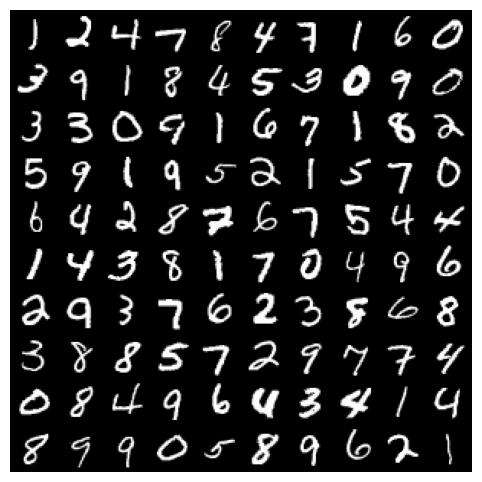

In [242]:
# TODO: Use the plot_image function to plot the images
plot_image(train_features)

# Training Loop

In [243]:
# Define VAE loss
# def vae_loss(reconstructed_x, x, mu, logvar):
#     # TODO: Implement the VAE loss function
#     reconstruction_loss = F.mse_loss(x, reconstructed_x)
#     reconstruction_loss *= 28*28
#     kl_loss = 1 + logvar - mu**2 - torch.exp(logvar)
#     kl_loss = torch.mean(kl_loss) * -0.5
#     vae_loss = torch.mean(reconstruction_loss + kl_loss)
#     return vae_loss

# inherit nn.Module to allow automatic backprop
class VAE_Loss(nn.Module):
    def __init__(self, input_size):
        super(VAE_Loss, self).__init__()
        self.scale = input_size

    def forward(self, reconstructed_x, x, mu, logvar):
        # TODO: Implement the VAE loss function
        reconstruction_loss = F.mse_loss(x, reconstructed_x)
        reconstruction_loss *= self.scale
        kl_loss = 1 + logvar - mu**2 - torch.exp(logvar)
        kl_loss = torch.mean(kl_loss) * -0.5
        vae_loss = torch.mean(reconstruction_loss + kl_loss)
        return vae_loss


In [244]:
print(DEVICE)

cpu


In [245]:
from tqdm import tqdm

# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.
NUM_EPOCHS = 100
model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS)
# .to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
vae_loss = VAE_Loss(28*28)
model.train()
train_losses = []
eval_losses = []
cumulative_train_loss = 0
cumulative_train_count = 0
# Training Loop
for epoch in tqdm(range(NUM_EPOCHS)):

    # TODO: Implement the training loop
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): 
        #enumerate(): This built-in Python function adds a counter to an iterable. 
        #It returns a tuple containing the index (starting from 0) and the value from the iterable.
        x, labels = data
        optimizer.zero_grad() # initialize gradients to zero

        # Forward pass
        x_reconstructed, mu, logvar = model.forward(x)
        loss = vae_loss(x_reconstructed, x, mu, logvar)

        # Backward pass and optimization
        loss.backward() # compute gradients
        optimizer.step() # update weights 

        running_loss += loss.item()
        if i % 100 == 99:    # Print loss every 100 mini-batches
            print(f'Epoch [{epoch + 1}], Batch [{i + 1}] loss: {running_loss / 100:.3f}')
            cumulative_train_loss += running_loss
            running_loss = 0.0
    
    train_losses.append(cumulative_train_loss/i/100)
    cumulative_train_loss = 0
    # TODO: Implement the evaluation loop
    with torch.no_grad():
        test_loss = 0.0
        for i, data in enumerate(testloader, 0): 
            #enumerate(): This built-in Python function adds a counter to an iterable. 
            #It returns a tuple containing the index (starting from 0) and the value from the iterable.
            x, labels = data

            # Forward pass
            
            x_reconstructed, mu, logvar = model(x)
            loss = vae_loss(x_reconstructed, x, mu, logvar)

            test_loss += loss.item()/100
        print(f'Epoch [{epoch + 1}], testloss: {test_loss:.3f}')
        
        eval_losses.append(test_loss/i)
print('Finished Training')

OrderedDict({'conv_layer_0': Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), 'RELU_e_0': ReLU(), 'conv_layer_1': Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), 'RELU_e_1': ReLU(), 'flatten': Flatten(start_dim=1, end_dim=-1)})
OrderedDict({'conv_layer_0': ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)), 'RELU_d_0': ReLU(), 'conv_layer_1': ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)), 'RELU_d_1': ReLU()})


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1], Batch [100] loss: 634.536
Epoch [1], Batch [200] loss: 90.587
Epoch [1], Batch [300] loss: 88.955
Epoch [1], Batch [400] loss: 88.346
Epoch [1], Batch [500] loss: 87.825
Epoch [1], Batch [600] loss: 87.125


  1%|          | 1/100 [00:20<33:36, 20.36s/it]

Epoch [1], testloss: 88.136
Epoch [2], Batch [100] loss: 86.658
Epoch [2], Batch [200] loss: 85.852
Epoch [2], Batch [300] loss: 84.972
Epoch [2], Batch [400] loss: 84.980
Epoch [2], Batch [500] loss: 84.522
Epoch [2], Batch [600] loss: 84.315


  2%|▏         | 2/100 [00:41<34:05, 20.87s/it]

Epoch [2], testloss: 84.974
Epoch [3], Batch [100] loss: 83.646
Epoch [3], Batch [200] loss: 82.844
Epoch [3], Batch [300] loss: 82.919
Epoch [3], Batch [400] loss: 82.720
Epoch [3], Batch [500] loss: 81.562
Epoch [3], Batch [600] loss: 81.318


  3%|▎         | 3/100 [01:03<34:43, 21.48s/it]

Epoch [3], testloss: 82.596
Epoch [4], Batch [100] loss: 80.835
Epoch [4], Batch [200] loss: 80.158
Epoch [4], Batch [300] loss: 80.163
Epoch [4], Batch [400] loss: 79.795
Epoch [4], Batch [500] loss: 78.858
Epoch [4], Batch [600] loss: 78.928


  4%|▍         | 4/100 [01:25<34:47, 21.74s/it]

Epoch [4], testloss: 79.811
Epoch [5], Batch [100] loss: 78.868
Epoch [5], Batch [200] loss: 78.151
Epoch [5], Batch [300] loss: 77.429
Epoch [5], Batch [400] loss: 77.853
Epoch [5], Batch [500] loss: 77.132
Epoch [5], Batch [600] loss: 76.869


  5%|▌         | 5/100 [01:48<34:52, 22.02s/it]

Epoch [5], testloss: 78.037
Epoch [6], Batch [100] loss: 77.011
Epoch [6], Batch [200] loss: 76.314
Epoch [6], Batch [300] loss: 76.333
Epoch [6], Batch [400] loss: 76.637
Epoch [6], Batch [500] loss: 76.183
Epoch [6], Batch [600] loss: 75.998


  6%|▌         | 6/100 [02:10<34:44, 22.18s/it]

Epoch [6], testloss: 77.075
Epoch [7], Batch [100] loss: 75.789
Epoch [7], Batch [200] loss: 76.049
Epoch [7], Batch [300] loss: 75.844
Epoch [7], Batch [400] loss: 75.701
Epoch [7], Batch [500] loss: 75.853
Epoch [7], Batch [600] loss: 75.415


  7%|▋         | 7/100 [02:33<34:28, 22.24s/it]

Epoch [7], testloss: 76.563
Epoch [8], Batch [100] loss: 75.605
Epoch [8], Batch [200] loss: 75.188
Epoch [8], Batch [300] loss: 75.026
Epoch [8], Batch [400] loss: 74.695
Epoch [8], Batch [500] loss: 74.984
Epoch [8], Batch [600] loss: 74.463


  8%|▊         | 8/100 [02:55<34:17, 22.36s/it]

Epoch [8], testloss: 75.722
Epoch [9], Batch [100] loss: 74.616
Epoch [9], Batch [200] loss: 74.149
Epoch [9], Batch [300] loss: 74.776
Epoch [9], Batch [400] loss: 74.228
Epoch [9], Batch [500] loss: 74.062
Epoch [9], Batch [600] loss: 73.814


  9%|▉         | 9/100 [03:18<33:57, 22.39s/it]

Epoch [9], testloss: 74.883
Epoch [10], Batch [100] loss: 74.135
Epoch [10], Batch [200] loss: 73.548
Epoch [10], Batch [300] loss: 73.655
Epoch [10], Batch [400] loss: 73.405
Epoch [10], Batch [500] loss: 73.079
Epoch [10], Batch [600] loss: 73.583


 10%|█         | 10/100 [03:40<33:32, 22.36s/it]

Epoch [10], testloss: 74.188
Epoch [11], Batch [100] loss: 73.351
Epoch [11], Batch [200] loss: 73.545
Epoch [11], Batch [300] loss: 72.980
Epoch [11], Batch [400] loss: 72.476
Epoch [11], Batch [500] loss: 72.879
Epoch [11], Batch [600] loss: 71.899


 11%|█         | 11/100 [04:03<33:27, 22.55s/it]

Epoch [11], testloss: 73.514
Epoch [12], Batch [100] loss: 72.395
Epoch [12], Batch [200] loss: 72.487
Epoch [12], Batch [300] loss: 71.969
Epoch [12], Batch [400] loss: 72.598
Epoch [12], Batch [500] loss: 71.718
Epoch [12], Batch [600] loss: 72.179


 12%|█▏        | 12/100 [04:26<33:08, 22.60s/it]

Epoch [12], testloss: 73.061
Epoch [13], Batch [100] loss: 71.464
Epoch [13], Batch [200] loss: 72.034
Epoch [13], Batch [300] loss: 72.172
Epoch [13], Batch [400] loss: 71.666
Epoch [13], Batch [500] loss: 71.677
Epoch [13], Batch [600] loss: 71.534


 13%|█▎        | 13/100 [04:49<33:02, 22.78s/it]

Epoch [13], testloss: 72.252
Epoch [14], Batch [100] loss: 71.261
Epoch [14], Batch [200] loss: 70.827
Epoch [14], Batch [300] loss: 70.704
Epoch [14], Batch [400] loss: 70.342
Epoch [14], Batch [500] loss: 70.320
Epoch [14], Batch [600] loss: 69.661


 14%|█▍        | 14/100 [05:12<32:36, 22.75s/it]

Epoch [14], testloss: 71.003
Epoch [15], Batch [100] loss: 70.317
Epoch [15], Batch [200] loss: 69.481
Epoch [15], Batch [300] loss: 69.703
Epoch [15], Batch [400] loss: 69.889
Epoch [15], Batch [500] loss: 70.057
Epoch [15], Batch [600] loss: 69.363


 15%|█▌        | 15/100 [05:34<32:11, 22.72s/it]

Epoch [15], testloss: 70.537
Epoch [16], Batch [100] loss: 69.649
Epoch [16], Batch [200] loss: 69.030
Epoch [16], Batch [300] loss: 69.460
Epoch [16], Batch [400] loss: 69.278
Epoch [16], Batch [500] loss: 69.017
Epoch [16], Batch [600] loss: 68.381


 16%|█▌        | 16/100 [05:57<31:56, 22.82s/it]

Epoch [16], testloss: 69.456
Epoch [17], Batch [100] loss: 67.900
Epoch [17], Batch [200] loss: 68.369
Epoch [17], Batch [300] loss: 68.082
Epoch [17], Batch [400] loss: 67.202
Epoch [17], Batch [500] loss: 67.351
Epoch [17], Batch [600] loss: 66.975


 17%|█▋        | 17/100 [06:21<31:40, 22.90s/it]

Epoch [17], testloss: 67.323
Epoch [18], Batch [100] loss: 66.034
Epoch [18], Batch [200] loss: 65.736
Epoch [18], Batch [300] loss: 64.672
Epoch [18], Batch [400] loss: 63.995
Epoch [18], Batch [500] loss: 63.774
Epoch [18], Batch [600] loss: 63.500


 18%|█▊        | 18/100 [06:43<31:13, 22.84s/it]

Epoch [18], testloss: 64.158
Epoch [19], Batch [100] loss: 63.038
Epoch [19], Batch [200] loss: 62.086
Epoch [19], Batch [300] loss: 61.185
Epoch [19], Batch [400] loss: 60.402
Epoch [19], Batch [500] loss: 59.178
Epoch [19], Batch [600] loss: 57.255


 19%|█▉        | 19/100 [07:06<30:56, 22.91s/it]

Epoch [19], testloss: 56.993
Epoch [20], Batch [100] loss: 55.247
Epoch [20], Batch [200] loss: 53.796
Epoch [20], Batch [300] loss: 52.749
Epoch [20], Batch [400] loss: 52.224
Epoch [20], Batch [500] loss: 52.076
Epoch [20], Batch [600] loss: 51.260


 20%|██        | 20/100 [07:30<30:57, 23.22s/it]

Epoch [20], testloss: 51.058
Epoch [21], Batch [100] loss: 50.363
Epoch [21], Batch [200] loss: 48.593
Epoch [21], Batch [300] loss: 47.369
Epoch [21], Batch [400] loss: 45.631
Epoch [21], Batch [500] loss: 44.375
Epoch [21], Batch [600] loss: 41.640


 21%|██        | 21/100 [07:53<30:28, 23.15s/it]

Epoch [21], testloss: 40.874
Epoch [22], Batch [100] loss: 39.346
Epoch [22], Batch [200] loss: 32.592
Epoch [22], Batch [300] loss: 26.249
Epoch [22], Batch [400] loss: 22.042
Epoch [22], Batch [500] loss: 19.316
Epoch [22], Batch [600] loss: 17.929


 22%|██▏       | 22/100 [08:16<30:03, 23.12s/it]

Epoch [22], testloss: 17.086
Epoch [23], Batch [100] loss: 17.203
Epoch [23], Batch [200] loss: 16.683
Epoch [23], Batch [300] loss: 16.543
Epoch [23], Batch [400] loss: 16.283
Epoch [23], Batch [500] loss: 15.954
Epoch [23], Batch [600] loss: 15.835


 23%|██▎       | 23/100 [08:39<29:31, 23.00s/it]

Epoch [23], testloss: 15.425
Epoch [24], Batch [100] loss: 15.454
Epoch [24], Batch [200] loss: 15.437
Epoch [24], Batch [300] loss: 15.274
Epoch [24], Batch [400] loss: 15.089
Epoch [24], Batch [500] loss: 14.927
Epoch [24], Batch [600] loss: 14.748


 24%|██▍       | 24/100 [09:02<29:09, 23.02s/it]

Epoch [24], testloss: 14.425
Epoch [25], Batch [100] loss: 14.566
Epoch [25], Batch [200] loss: 14.605
Epoch [25], Batch [300] loss: 14.426
Epoch [25], Batch [400] loss: 14.236
Epoch [25], Batch [500] loss: 14.188
Epoch [25], Batch [600] loss: 14.051


 25%|██▌       | 25/100 [09:25<28:37, 22.91s/it]

Epoch [25], testloss: 14.008
Epoch [26], Batch [100] loss: 13.813
Epoch [26], Batch [200] loss: 13.880
Epoch [26], Batch [300] loss: 13.780
Epoch [26], Batch [400] loss: 13.726
Epoch [26], Batch [500] loss: 13.595
Epoch [26], Batch [600] loss: 13.576


 26%|██▌       | 26/100 [09:48<28:28, 23.08s/it]

Epoch [26], testloss: 13.258
Epoch [27], Batch [100] loss: 13.338
Epoch [27], Batch [200] loss: 13.278
Epoch [27], Batch [300] loss: 13.245
Epoch [27], Batch [400] loss: 13.224
Epoch [27], Batch [500] loss: 13.051
Epoch [27], Batch [600] loss: 13.206


 27%|██▋       | 27/100 [10:11<27:54, 22.93s/it]

Epoch [27], testloss: 13.287
Epoch [28], Batch [100] loss: 12.933
Epoch [28], Batch [200] loss: 13.020
Epoch [28], Batch [300] loss: 12.838
Epoch [28], Batch [400] loss: 12.768
Epoch [28], Batch [500] loss: 12.846
Epoch [28], Batch [600] loss: 12.661


 28%|██▊       | 28/100 [10:33<27:24, 22.84s/it]

Epoch [28], testloss: 12.462
Epoch [29], Batch [100] loss: 12.543
Epoch [29], Batch [200] loss: 12.535
Epoch [29], Batch [300] loss: 12.511
Epoch [29], Batch [400] loss: 12.547
Epoch [29], Batch [500] loss: 12.392
Epoch [29], Batch [600] loss: 12.340


 29%|██▉       | 29/100 [10:56<27:00, 22.83s/it]

Epoch [29], testloss: 12.140
Epoch [30], Batch [100] loss: 12.262
Epoch [30], Batch [200] loss: 12.190
Epoch [30], Batch [300] loss: 12.224
Epoch [30], Batch [400] loss: 12.095
Epoch [30], Batch [500] loss: 12.089
Epoch [30], Batch [600] loss: 12.001


 30%|███       | 30/100 [11:19<26:35, 22.80s/it]

Epoch [30], testloss: 11.920
Epoch [31], Batch [100] loss: 12.045
Epoch [31], Batch [200] loss: 11.989
Epoch [31], Batch [300] loss: 11.905
Epoch [31], Batch [400] loss: 11.741
Epoch [31], Batch [500] loss: 11.794
Epoch [31], Batch [600] loss: 11.834


 31%|███       | 31/100 [11:42<26:10, 22.77s/it]

Epoch [31], testloss: 11.640
Epoch [32], Batch [100] loss: 11.643
Epoch [32], Batch [200] loss: 11.836
Epoch [32], Batch [300] loss: 11.759
Epoch [32], Batch [400] loss: 11.624
Epoch [32], Batch [500] loss: 11.601
Epoch [32], Batch [600] loss: 11.517


 32%|███▏      | 32/100 [12:05<25:52, 22.82s/it]

Epoch [32], testloss: 11.473
Epoch [33], Batch [100] loss: 11.491
Epoch [33], Batch [200] loss: 11.558
Epoch [33], Batch [300] loss: 11.494
Epoch [33], Batch [400] loss: 11.392
Epoch [33], Batch [500] loss: 11.388
Epoch [33], Batch [600] loss: 11.385


 33%|███▎      | 33/100 [12:28<25:33, 22.88s/it]

Epoch [33], testloss: 11.200
Epoch [34], Batch [100] loss: 11.315
Epoch [34], Batch [200] loss: 11.207
Epoch [34], Batch [300] loss: 11.518
Epoch [34], Batch [400] loss: 11.158
Epoch [34], Batch [500] loss: 11.212
Epoch [34], Batch [600] loss: 11.132


 34%|███▍      | 34/100 [12:51<25:16, 22.98s/it]

Epoch [34], testloss: 11.086
Epoch [35], Batch [100] loss: 11.139
Epoch [35], Batch [200] loss: 11.052
Epoch [35], Batch [300] loss: 11.100
Epoch [35], Batch [400] loss: 11.071
Epoch [35], Batch [500] loss: 11.087
Epoch [35], Batch [600] loss: 10.968


 35%|███▌      | 35/100 [13:14<24:49, 22.92s/it]

Epoch [35], testloss: 11.029
Epoch [36], Batch [100] loss: 10.965
Epoch [36], Batch [200] loss: 10.837
Epoch [36], Batch [300] loss: 10.884
Epoch [36], Batch [400] loss: 10.886
Epoch [36], Batch [500] loss: 10.923
Epoch [36], Batch [600] loss: 10.916


 36%|███▌      | 36/100 [13:37<24:31, 23.00s/it]

Epoch [36], testloss: 10.737
Epoch [37], Batch [100] loss: 10.778
Epoch [37], Batch [200] loss: 10.771
Epoch [37], Batch [300] loss: 10.816
Epoch [37], Batch [400] loss: 10.765
Epoch [37], Batch [500] loss: 10.929
Epoch [37], Batch [600] loss: 10.753


 37%|███▋      | 37/100 [14:00<24:12, 23.05s/it]

Epoch [37], testloss: 10.627
Epoch [38], Batch [100] loss: 10.669
Epoch [38], Batch [200] loss: 10.674
Epoch [38], Batch [300] loss: 10.583
Epoch [38], Batch [400] loss: 10.644
Epoch [38], Batch [500] loss: 10.739
Epoch [38], Batch [600] loss: 10.573


 38%|███▊      | 38/100 [14:23<23:47, 23.02s/it]

Epoch [38], testloss: 10.639
Epoch [39], Batch [100] loss: 10.554
Epoch [39], Batch [200] loss: 10.511
Epoch [39], Batch [300] loss: 10.581
Epoch [39], Batch [400] loss: 10.563
Epoch [39], Batch [500] loss: 10.567
Epoch [39], Batch [600] loss: 10.522


 39%|███▉      | 39/100 [14:46<23:25, 23.04s/it]

Epoch [39], testloss: 10.519
Epoch [40], Batch [100] loss: 10.449
Epoch [40], Batch [200] loss: 10.441
Epoch [40], Batch [300] loss: 10.460
Epoch [40], Batch [400] loss: 10.468
Epoch [40], Batch [500] loss: 10.386
Epoch [40], Batch [600] loss: 10.521


 40%|████      | 40/100 [15:09<23:01, 23.03s/it]

Epoch [40], testloss: 10.387
Epoch [41], Batch [100] loss: 10.232
Epoch [41], Batch [200] loss: 10.378
Epoch [41], Batch [300] loss: 10.398
Epoch [41], Batch [400] loss: 10.394
Epoch [41], Batch [500] loss: 10.383
Epoch [41], Batch [600] loss: 10.321


 41%|████      | 41/100 [15:32<22:37, 23.00s/it]

Epoch [41], testloss: 10.251
Epoch [42], Batch [100] loss: 10.237
Epoch [42], Batch [200] loss: 10.199
Epoch [42], Batch [300] loss: 10.395
Epoch [42], Batch [400] loss: 10.254
Epoch [42], Batch [500] loss: 10.265
Epoch [42], Batch [600] loss: 10.258


 42%|████▏     | 42/100 [15:55<22:16, 23.04s/it]

Epoch [42], testloss: 10.198
Epoch [43], Batch [100] loss: 10.241
Epoch [43], Batch [200] loss: 10.202
Epoch [43], Batch [300] loss: 10.111
Epoch [43], Batch [400] loss: 10.184
Epoch [43], Batch [500] loss: 10.151
Epoch [43], Batch [600] loss: 10.189


 43%|████▎     | 43/100 [16:18<21:50, 22.99s/it]

Epoch [43], testloss: 10.080
Epoch [44], Batch [100] loss: 10.185
Epoch [44], Batch [200] loss: 10.146
Epoch [44], Batch [300] loss: 10.100
Epoch [44], Batch [400] loss: 10.062
Epoch [44], Batch [500] loss: 10.094
Epoch [44], Batch [600] loss: 10.087


 44%|████▍     | 44/100 [16:41<21:28, 23.02s/it]

Epoch [44], testloss: 10.086
Epoch [45], Batch [100] loss: 10.024
Epoch [45], Batch [200] loss: 10.048
Epoch [45], Batch [300] loss: 10.046
Epoch [45], Batch [400] loss: 10.015
Epoch [45], Batch [500] loss: 10.104
Epoch [45], Batch [600] loss: 10.038


 45%|████▌     | 45/100 [17:04<21:09, 23.08s/it]

Epoch [45], testloss: 10.051
Epoch [46], Batch [100] loss: 10.048
Epoch [46], Batch [200] loss: 9.967
Epoch [46], Batch [300] loss: 9.935
Epoch [46], Batch [400] loss: 10.011
Epoch [46], Batch [500] loss: 9.962
Epoch [46], Batch [600] loss: 10.017


 46%|████▌     | 46/100 [17:27<20:43, 23.03s/it]

Epoch [46], testloss: 9.963
Epoch [47], Batch [100] loss: 9.923
Epoch [47], Batch [200] loss: 9.870
Epoch [47], Batch [300] loss: 9.945
Epoch [47], Batch [400] loss: 9.956
Epoch [47], Batch [500] loss: 9.886
Epoch [47], Batch [600] loss: 9.949


 47%|████▋     | 47/100 [17:52<20:51, 23.61s/it]

Epoch [47], testloss: 9.897
Epoch [48], Batch [100] loss: 9.828
Epoch [48], Batch [200] loss: 9.884
Epoch [48], Batch [300] loss: 9.828
Epoch [48], Batch [400] loss: 9.829
Epoch [48], Batch [500] loss: 9.873
Epoch [48], Batch [600] loss: 9.867


 48%|████▊     | 48/100 [18:16<20:29, 23.64s/it]

Epoch [48], testloss: 9.805
Epoch [49], Batch [100] loss: 9.725
Epoch [49], Batch [200] loss: 9.827
Epoch [49], Batch [300] loss: 9.854
Epoch [49], Batch [400] loss: 9.792
Epoch [49], Batch [500] loss: 9.831
Epoch [49], Batch [600] loss: 9.822


 49%|████▉     | 49/100 [18:39<19:58, 23.51s/it]

Epoch [49], testloss: 9.803
Epoch [50], Batch [100] loss: 9.756
Epoch [50], Batch [200] loss: 9.778
Epoch [50], Batch [300] loss: 9.730
Epoch [50], Batch [400] loss: 9.721
Epoch [50], Batch [500] loss: 9.723
Epoch [50], Batch [600] loss: 9.769


 50%|█████     | 50/100 [19:03<19:35, 23.50s/it]

Epoch [50], testloss: 9.836
Epoch [51], Batch [100] loss: 9.698
Epoch [51], Batch [200] loss: 9.763
Epoch [51], Batch [300] loss: 9.715
Epoch [51], Batch [400] loss: 9.704
Epoch [51], Batch [500] loss: 9.725
Epoch [51], Batch [600] loss: 9.703


 51%|█████     | 51/100 [19:26<19:06, 23.40s/it]

Epoch [51], testloss: 9.741
Epoch [52], Batch [100] loss: 9.684
Epoch [52], Batch [200] loss: 9.661
Epoch [52], Batch [300] loss: 9.620
Epoch [52], Batch [400] loss: 9.654
Epoch [52], Batch [500] loss: 9.656
Epoch [52], Batch [600] loss: 9.665


 52%|█████▏    | 52/100 [19:50<18:50, 23.56s/it]

Epoch [52], testloss: 9.689
Epoch [53], Batch [100] loss: 9.569
Epoch [53], Batch [200] loss: 9.575
Epoch [53], Batch [300] loss: 9.638
Epoch [53], Batch [400] loss: 9.693
Epoch [53], Batch [500] loss: 9.628
Epoch [53], Batch [600] loss: 9.631


 53%|█████▎    | 53/100 [20:13<18:19, 23.39s/it]

Epoch [53], testloss: 9.612
Epoch [54], Batch [100] loss: 9.587
Epoch [54], Batch [200] loss: 9.557
Epoch [54], Batch [300] loss: 9.588
Epoch [54], Batch [400] loss: 9.559
Epoch [54], Batch [500] loss: 9.638
Epoch [54], Batch [600] loss: 9.545


 54%|█████▍    | 54/100 [20:36<17:54, 23.35s/it]

Epoch [54], testloss: 9.575
Epoch [55], Batch [100] loss: 9.557
Epoch [55], Batch [200] loss: 9.547
Epoch [55], Batch [300] loss: 9.615
Epoch [55], Batch [400] loss: 9.524
Epoch [55], Batch [500] loss: 9.556
Epoch [55], Batch [600] loss: 9.479


 55%|█████▌    | 55/100 [20:59<17:31, 23.37s/it]

Epoch [55], testloss: 9.606
Epoch [56], Batch [100] loss: 9.434
Epoch [56], Batch [200] loss: 9.502
Epoch [56], Batch [300] loss: 9.511
Epoch [56], Batch [400] loss: 9.532
Epoch [56], Batch [500] loss: 9.562
Epoch [56], Batch [600] loss: 9.440


 56%|█████▌    | 56/100 [21:22<17:04, 23.27s/it]

Epoch [56], testloss: 9.540
Epoch [57], Batch [100] loss: 9.411
Epoch [57], Batch [200] loss: 9.462
Epoch [57], Batch [300] loss: 9.453
Epoch [57], Batch [400] loss: 9.514
Epoch [57], Batch [500] loss: 9.523
Epoch [57], Batch [600] loss: 9.433


 57%|█████▋    | 57/100 [21:45<16:38, 23.22s/it]

Epoch [57], testloss: 9.567
Epoch [58], Batch [100] loss: 9.353
Epoch [58], Batch [200] loss: 9.439
Epoch [58], Batch [300] loss: 9.373
Epoch [58], Batch [400] loss: 9.486
Epoch [58], Batch [500] loss: 9.483
Epoch [58], Batch [600] loss: 9.483


 58%|█████▊    | 58/100 [22:09<16:20, 23.34s/it]

Epoch [58], testloss: 9.553
Epoch [59], Batch [100] loss: 9.426
Epoch [59], Batch [200] loss: 9.353
Epoch [59], Batch [300] loss: 9.409
Epoch [59], Batch [400] loss: 9.416
Epoch [59], Batch [500] loss: 9.369
Epoch [59], Batch [600] loss: 9.426


 59%|█████▉    | 59/100 [22:32<15:57, 23.36s/it]

Epoch [59], testloss: 9.477
Epoch [60], Batch [100] loss: 9.344
Epoch [60], Batch [200] loss: 9.324
Epoch [60], Batch [300] loss: 9.417
Epoch [60], Batch [400] loss: 9.374
Epoch [60], Batch [500] loss: 9.395
Epoch [60], Batch [600] loss: 9.383


 60%|██████    | 60/100 [22:56<15:30, 23.26s/it]

Epoch [60], testloss: 9.428
Epoch [61], Batch [100] loss: 9.328
Epoch [61], Batch [200] loss: 9.308
Epoch [61], Batch [300] loss: 9.352
Epoch [61], Batch [400] loss: 9.359
Epoch [61], Batch [500] loss: 9.303
Epoch [61], Batch [600] loss: 9.427


 61%|██████    | 61/100 [23:19<15:08, 23.29s/it]

Epoch [61], testloss: 9.475
Epoch [62], Batch [100] loss: 9.322
Epoch [62], Batch [200] loss: 9.241
Epoch [62], Batch [300] loss: 9.372
Epoch [62], Batch [400] loss: 9.322
Epoch [62], Batch [500] loss: 9.347
Epoch [62], Batch [600] loss: 9.363


 62%|██████▏   | 62/100 [23:42<14:40, 23.16s/it]

Epoch [62], testloss: 9.483
Epoch [63], Batch [100] loss: 9.303
Epoch [63], Batch [200] loss: 9.266
Epoch [63], Batch [300] loss: 9.306
Epoch [63], Batch [400] loss: 9.348
Epoch [63], Batch [500] loss: 9.231
Epoch [63], Batch [600] loss: 9.287


 63%|██████▎   | 63/100 [24:05<14:23, 23.34s/it]

Epoch [63], testloss: 9.313
Epoch [64], Batch [100] loss: 9.227
Epoch [64], Batch [200] loss: 9.219
Epoch [64], Batch [300] loss: 9.299
Epoch [64], Batch [400] loss: 9.268
Epoch [64], Batch [500] loss: 9.286
Epoch [64], Batch [600] loss: 9.262


 64%|██████▍   | 64/100 [24:29<13:59, 23.32s/it]

Epoch [64], testloss: 9.482
Epoch [65], Batch [100] loss: 9.201
Epoch [65], Batch [200] loss: 9.227
Epoch [65], Batch [300] loss: 9.245
Epoch [65], Batch [400] loss: 9.339
Epoch [65], Batch [500] loss: 9.186
Epoch [65], Batch [600] loss: 9.298


 65%|██████▌   | 65/100 [24:52<13:37, 23.35s/it]

Epoch [65], testloss: 9.303
Epoch [66], Batch [100] loss: 9.165
Epoch [66], Batch [200] loss: 9.162
Epoch [66], Batch [300] loss: 9.328
Epoch [66], Batch [400] loss: 9.195
Epoch [66], Batch [500] loss: 9.232
Epoch [66], Batch [600] loss: 9.204


 66%|██████▌   | 66/100 [25:16<13:16, 23.43s/it]

Epoch [66], testloss: 9.468
Epoch [67], Batch [100] loss: 9.144
Epoch [67], Batch [200] loss: 9.178
Epoch [67], Batch [300] loss: 9.245
Epoch [67], Batch [400] loss: 9.191
Epoch [67], Batch [500] loss: 9.181
Epoch [67], Batch [600] loss: 9.251


 67%|██████▋   | 67/100 [25:39<12:51, 23.37s/it]

Epoch [67], testloss: 9.300
Epoch [68], Batch [100] loss: 9.149
Epoch [68], Batch [200] loss: 9.188
Epoch [68], Batch [300] loss: 9.168
Epoch [68], Batch [400] loss: 9.210
Epoch [68], Batch [500] loss: 9.165
Epoch [68], Batch [600] loss: 9.138


 68%|██████▊   | 68/100 [26:03<12:31, 23.48s/it]

Epoch [68], testloss: 9.232
Epoch [69], Batch [100] loss: 9.153
Epoch [69], Batch [200] loss: 9.177
Epoch [69], Batch [300] loss: 9.122
Epoch [69], Batch [400] loss: 9.171
Epoch [69], Batch [500] loss: 9.158
Epoch [69], Batch [600] loss: 9.131


 69%|██████▉   | 69/100 [26:26<12:06, 23.43s/it]

Epoch [69], testloss: 9.268
Epoch [70], Batch [100] loss: 9.118
Epoch [70], Batch [200] loss: 9.087
Epoch [70], Batch [300] loss: 9.151
Epoch [70], Batch [400] loss: 9.116
Epoch [70], Batch [500] loss: 9.125
Epoch [70], Batch [600] loss: 9.180


 70%|███████   | 70/100 [26:49<11:41, 23.38s/it]

Epoch [70], testloss: 9.256
Epoch [71], Batch [100] loss: 9.135
Epoch [71], Batch [200] loss: 9.062
Epoch [71], Batch [300] loss: 9.098
Epoch [71], Batch [400] loss: 9.156
Epoch [71], Batch [500] loss: 9.123
Epoch [71], Batch [600] loss: 9.179


 71%|███████   | 71/100 [27:13<11:16, 23.34s/it]

Epoch [71], testloss: 9.179
Epoch [72], Batch [100] loss: 9.038
Epoch [72], Batch [200] loss: 9.095
Epoch [72], Batch [300] loss: 9.078
Epoch [72], Batch [400] loss: 9.098
Epoch [72], Batch [500] loss: 9.135
Epoch [72], Batch [600] loss: 9.122


 72%|███████▏  | 72/100 [27:36<10:53, 23.33s/it]

Epoch [72], testloss: 9.153
Epoch [73], Batch [100] loss: 9.017
Epoch [73], Batch [200] loss: 9.103
Epoch [73], Batch [300] loss: 9.043
Epoch [73], Batch [400] loss: 9.082
Epoch [73], Batch [500] loss: 9.048
Epoch [73], Batch [600] loss: 9.148


 73%|███████▎  | 73/100 [28:00<10:32, 23.43s/it]

Epoch [73], testloss: 9.362
Epoch [74], Batch [100] loss: 9.048
Epoch [74], Batch [200] loss: 8.992
Epoch [74], Batch [300] loss: 9.067
Epoch [74], Batch [400] loss: 9.046
Epoch [74], Batch [500] loss: 9.098
Epoch [74], Batch [600] loss: 9.067


 74%|███████▍  | 74/100 [28:23<10:07, 23.36s/it]

Epoch [74], testloss: 9.134
Epoch [75], Batch [100] loss: 8.969
Epoch [75], Batch [200] loss: 9.051
Epoch [75], Batch [300] loss: 9.031
Epoch [75], Batch [400] loss: 9.090
Epoch [75], Batch [500] loss: 9.028
Epoch [75], Batch [600] loss: 9.064


 75%|███████▌  | 75/100 [28:46<09:41, 23.27s/it]

Epoch [75], testloss: 9.188
Epoch [76], Batch [100] loss: 8.966
Epoch [76], Batch [200] loss: 9.035
Epoch [76], Batch [300] loss: 8.960
Epoch [76], Batch [400] loss: 9.047
Epoch [76], Batch [500] loss: 9.028
Epoch [76], Batch [600] loss: 9.054


 76%|███████▌  | 76/100 [29:09<09:19, 23.32s/it]

Epoch [76], testloss: 9.093
Epoch [77], Batch [100] loss: 8.947
Epoch [77], Batch [200] loss: 9.013
Epoch [77], Batch [300] loss: 9.033
Epoch [77], Batch [400] loss: 9.030
Epoch [77], Batch [500] loss: 9.019
Epoch [77], Batch [600] loss: 9.048


 77%|███████▋  | 77/100 [29:32<08:54, 23.26s/it]

Epoch [77], testloss: 9.068
Epoch [78], Batch [100] loss: 8.916
Epoch [78], Batch [200] loss: 8.968
Epoch [78], Batch [300] loss: 8.996
Epoch [78], Batch [400] loss: 9.043
Epoch [78], Batch [500] loss: 9.011
Epoch [78], Batch [600] loss: 9.024


 78%|███████▊  | 78/100 [29:56<08:33, 23.32s/it]

Epoch [78], testloss: 9.095
Epoch [79], Batch [100] loss: 8.978
Epoch [79], Batch [200] loss: 8.957
Epoch [79], Batch [300] loss: 8.977
Epoch [79], Batch [400] loss: 9.010
Epoch [79], Batch [500] loss: 8.986
Epoch [79], Batch [600] loss: 8.918


 79%|███████▉  | 79/100 [30:19<08:07, 23.23s/it]

Epoch [79], testloss: 9.090
Epoch [80], Batch [100] loss: 8.931
Epoch [80], Batch [200] loss: 8.963
Epoch [80], Batch [300] loss: 8.915
Epoch [80], Batch [400] loss: 8.988
Epoch [80], Batch [500] loss: 9.061
Epoch [80], Batch [600] loss: 8.953


 80%|████████  | 80/100 [30:42<07:43, 23.17s/it]

Epoch [80], testloss: 9.049
Epoch [81], Batch [100] loss: 8.900
Epoch [81], Batch [200] loss: 8.932
Epoch [81], Batch [300] loss: 8.926
Epoch [81], Batch [400] loss: 8.969
Epoch [81], Batch [500] loss: 8.944
Epoch [81], Batch [600] loss: 8.962


 81%|████████  | 81/100 [31:05<07:21, 23.21s/it]

Epoch [81], testloss: 9.066
Epoch [82], Batch [100] loss: 8.864
Epoch [82], Batch [200] loss: 8.916
Epoch [82], Batch [300] loss: 8.968
Epoch [82], Batch [400] loss: 8.954
Epoch [82], Batch [500] loss: 9.044
Epoch [82], Batch [600] loss: 8.907


 82%|████████▏ | 82/100 [31:29<07:00, 23.35s/it]

Epoch [82], testloss: 9.079
Epoch [83], Batch [100] loss: 8.879
Epoch [83], Batch [200] loss: 8.935
Epoch [83], Batch [300] loss: 8.921
Epoch [83], Batch [400] loss: 8.925
Epoch [83], Batch [500] loss: 8.921
Epoch [83], Batch [600] loss: 8.923


 83%|████████▎ | 83/100 [31:53<06:39, 23.47s/it]

Epoch [83], testloss: 9.097
Epoch [84], Batch [100] loss: 8.868
Epoch [84], Batch [200] loss: 8.901
Epoch [84], Batch [300] loss: 8.946
Epoch [84], Batch [400] loss: 8.869
Epoch [84], Batch [500] loss: 8.892
Epoch [84], Batch [600] loss: 8.988


 84%|████████▍ | 84/100 [32:16<06:13, 23.35s/it]

Epoch [84], testloss: 9.004
Epoch [85], Batch [100] loss: 8.895
Epoch [85], Batch [200] loss: 8.862
Epoch [85], Batch [300] loss: 8.942
Epoch [85], Batch [400] loss: 8.863
Epoch [85], Batch [500] loss: 8.847
Epoch [85], Batch [600] loss: 8.932


 85%|████████▌ | 85/100 [32:39<05:48, 23.25s/it]

Epoch [85], testloss: 8.999
Epoch [86], Batch [100] loss: 8.798
Epoch [86], Batch [200] loss: 8.861
Epoch [86], Batch [300] loss: 8.889
Epoch [86], Batch [400] loss: 8.879
Epoch [86], Batch [500] loss: 8.992
Epoch [86], Batch [600] loss: 8.887


 86%|████████▌ | 86/100 [33:02<05:26, 23.31s/it]

Epoch [86], testloss: 8.977
Epoch [87], Batch [100] loss: 8.839
Epoch [87], Batch [200] loss: 8.853
Epoch [87], Batch [300] loss: 8.862
Epoch [87], Batch [400] loss: 8.899
Epoch [87], Batch [500] loss: 8.845
Epoch [87], Batch [600] loss: 8.878


 87%|████████▋ | 87/100 [33:25<05:02, 23.29s/it]

Epoch [87], testloss: 8.963
Epoch [88], Batch [100] loss: 8.733
Epoch [88], Batch [200] loss: 8.780
Epoch [88], Batch [300] loss: 8.869
Epoch [88], Batch [400] loss: 8.921
Epoch [88], Batch [500] loss: 8.892
Epoch [88], Batch [600] loss: 8.893


 88%|████████▊ | 88/100 [33:49<04:39, 23.27s/it]

Epoch [88], testloss: 8.967
Epoch [89], Batch [100] loss: 8.789
Epoch [89], Batch [200] loss: 8.794
Epoch [89], Batch [300] loss: 8.843
Epoch [89], Batch [400] loss: 8.873
Epoch [89], Batch [500] loss: 8.808
Epoch [89], Batch [600] loss: 8.924


 89%|████████▉ | 89/100 [34:12<04:16, 23.36s/it]

Epoch [89], testloss: 9.005
Epoch [90], Batch [100] loss: 8.754
Epoch [90], Batch [200] loss: 8.850
Epoch [90], Batch [300] loss: 8.856
Epoch [90], Batch [400] loss: 8.843
Epoch [90], Batch [500] loss: 8.838
Epoch [90], Batch [600] loss: 8.804


 90%|█████████ | 90/100 [34:35<03:52, 23.23s/it]

Epoch [90], testloss: 8.954
Epoch [91], Batch [100] loss: 8.724
Epoch [91], Batch [200] loss: 8.801
Epoch [91], Batch [300] loss: 8.802
Epoch [91], Batch [400] loss: 8.870
Epoch [91], Batch [500] loss: 8.849
Epoch [91], Batch [600] loss: 8.871


 91%|█████████ | 91/100 [34:58<03:29, 23.27s/it]

Epoch [91], testloss: 8.971
Epoch [92], Batch [100] loss: 8.775
Epoch [92], Batch [200] loss: 8.886
Epoch [92], Batch [300] loss: 8.799
Epoch [92], Batch [400] loss: 8.823
Epoch [92], Batch [500] loss: 8.764
Epoch [92], Batch [600] loss: 8.798


 92%|█████████▏| 92/100 [35:22<03:05, 23.20s/it]

Epoch [92], testloss: 8.972
Epoch [93], Batch [100] loss: 8.712
Epoch [93], Batch [200] loss: 8.789
Epoch [93], Batch [300] loss: 8.769
Epoch [93], Batch [400] loss: 8.832
Epoch [93], Batch [500] loss: 8.791
Epoch [93], Batch [600] loss: 8.823


 93%|█████████▎| 93/100 [35:45<02:43, 23.31s/it]

Epoch [93], testloss: 8.978
Epoch [94], Batch [100] loss: 8.748
Epoch [94], Batch [200] loss: 8.795
Epoch [94], Batch [300] loss: 8.823
Epoch [94], Batch [400] loss: 8.769
Epoch [94], Batch [500] loss: 8.761
Epoch [94], Batch [600] loss: 8.763


 94%|█████████▍| 94/100 [36:09<02:20, 23.35s/it]

Epoch [94], testloss: 8.896
Epoch [95], Batch [100] loss: 8.737
Epoch [95], Batch [200] loss: 8.781
Epoch [95], Batch [300] loss: 8.790
Epoch [95], Batch [400] loss: 8.728
Epoch [95], Batch [500] loss: 8.797
Epoch [95], Batch [600] loss: 8.795


 95%|█████████▌| 95/100 [36:32<01:56, 23.32s/it]

Epoch [95], testloss: 8.904
Epoch [96], Batch [100] loss: 8.687
Epoch [96], Batch [200] loss: 8.767
Epoch [96], Batch [300] loss: 8.767
Epoch [96], Batch [400] loss: 8.695
Epoch [96], Batch [500] loss: 8.790
Epoch [96], Batch [600] loss: 8.872


 96%|█████████▌| 96/100 [36:55<01:33, 23.37s/it]

Epoch [96], testloss: 8.919
Epoch [97], Batch [100] loss: 8.669
Epoch [97], Batch [200] loss: 8.717
Epoch [97], Batch [300] loss: 8.789
Epoch [97], Batch [400] loss: 8.743
Epoch [97], Batch [500] loss: 8.792
Epoch [97], Batch [600] loss: 8.769


 97%|█████████▋| 97/100 [37:19<01:10, 23.35s/it]

Epoch [97], testloss: 8.993
Epoch [98], Batch [100] loss: 8.718
Epoch [98], Batch [200] loss: 8.758
Epoch [98], Batch [300] loss: 8.715
Epoch [98], Batch [400] loss: 8.675
Epoch [98], Batch [500] loss: 8.807
Epoch [98], Batch [600] loss: 8.748


 98%|█████████▊| 98/100 [37:42<00:46, 23.28s/it]

Epoch [98], testloss: 8.879
Epoch [99], Batch [100] loss: 8.691
Epoch [99], Batch [200] loss: 8.704
Epoch [99], Batch [300] loss: 8.649
Epoch [99], Batch [400] loss: 8.811
Epoch [99], Batch [500] loss: 8.796
Epoch [99], Batch [600] loss: 8.715


 99%|█████████▉| 99/100 [38:05<00:23, 23.32s/it]

Epoch [99], testloss: 8.901
Epoch [100], Batch [100] loss: 8.666
Epoch [100], Batch [200] loss: 8.795
Epoch [100], Batch [300] loss: 8.670
Epoch [100], Batch [400] loss: 8.729
Epoch [100], Batch [500] loss: 8.697
Epoch [100], Batch [600] loss: 8.729


100%|██████████| 100/100 [38:28<00:00, 23.09s/it]

Epoch [100], testloss: 8.833
Finished Training


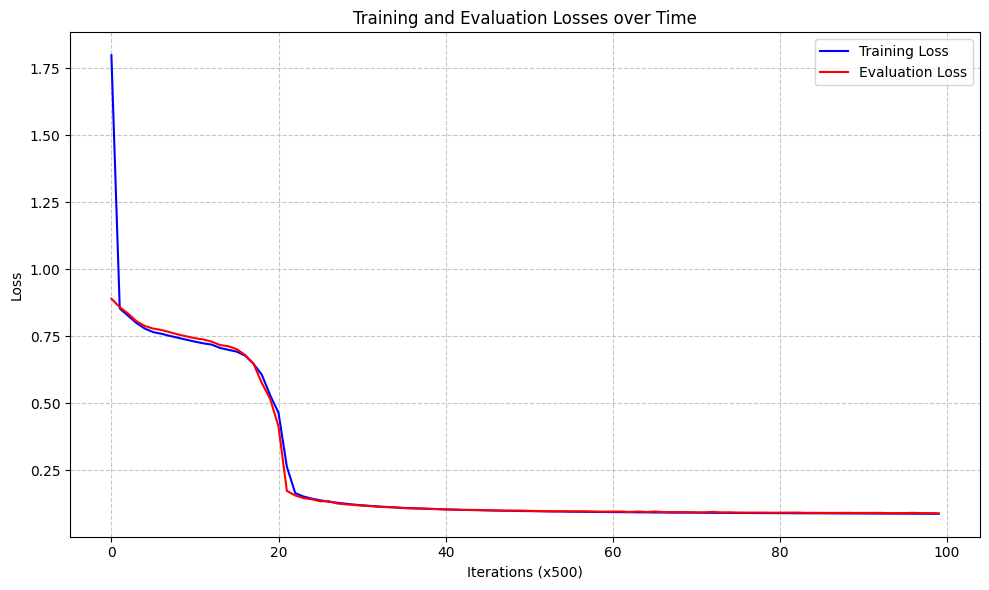

In [246]:
# Visualize your losses as your training progresses

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Iterations (x500)')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Visualizations

In [247]:
x[0].shape

torch.Size([1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1763928].


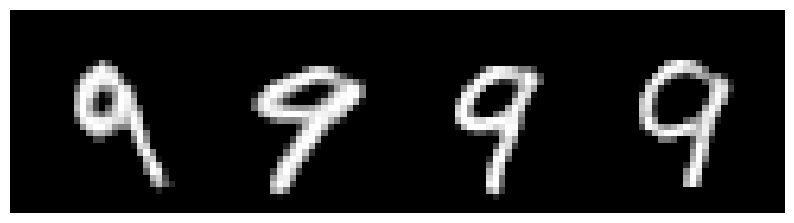

In [248]:
def visualize_generations(model, digit, num_examples):

    # TODO: Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images
    examples = []
    with torch.no_grad():
        not_done = True
        for i, data in enumerate(testloader, 0): 
            #enumerate(): This built-in Python function adds a counter to an iterable. 
            #It returns a tuple containing the index (starting from 0) and the value from the iterable.
            x, labels = data
            j = 0
            while not_done or j >=100:

                if labels[j] == digit:
                    x_reconstructed, mu, logvar = model(torch.reshape(x[j],(1,1,28,28)))
                    examples.append(x_reconstructed)
                    num_examples -= 1
                    not_done = True if num_examples > 0 else False
                j += 1
            if not not_done:
                break

    imgs = torch.cat(examples, dim=0)
    # print(f'imgs_shape: {imgs.shape}')
    plot_image(imgs, nrow=4)
    


digit = 9
num_examples = 4

visualize_generations(model, digit, num_examples)

/home/raze/Documents/University/semester_3/generative_ai/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.417s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.125238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.519012
[t-SNE] KL divergence after 300 iterations: 2.678135


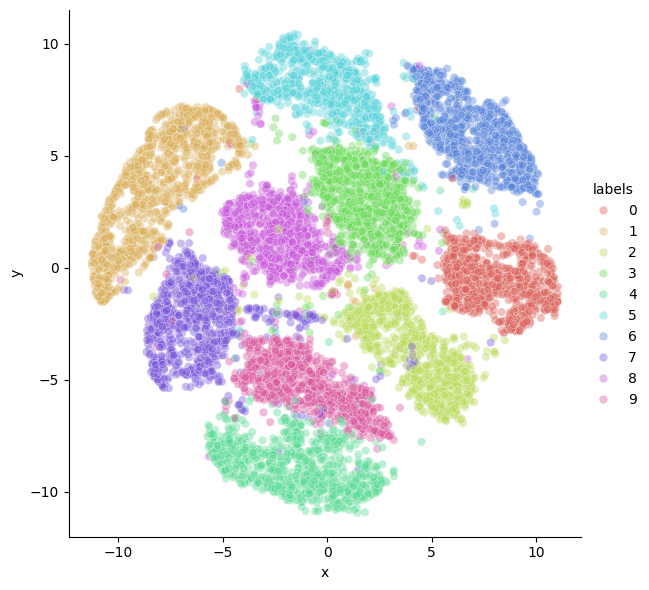

In [249]:
import seaborn as sns
from sklearn.manifold import TSNE

def visualize_latents(dataloader, model):
    # TODO: Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them
    dct = {}
    dct['labels'] = []
    latents = np.zeros((dataloader.dataset.__len__(),Z_DIMS*2))
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0): 
            #enumerate(): This built-in Python function adds a counter to an iterable. 
            #It returns a tuple containing the index (starting from 0) and the value from the iterable.
            x, labels = data

            # Forward pass
            _, mu, logvar = model(x)
            z = torch.cat([mu,logvar],dim=1)
            latents[i*100:(i+1)*100] = np.array(z)
            dct['labels'].extend(labels.numpy())
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(latents)
    dct['x'] = tsne_results[:,0]
    dct['y'] = tsne_results[:,1]
    sns.relplot(x='x', y='y', hue='labels',height=6,data=dct,
                palette=sns.color_palette("hls", 10),legend="full",alpha=0.4)


visualize_latents(testloader,model)

## Mid-Term Question

In [259]:
mu_0 = torch.tensor(np.zeros((20,1)))
logvar_0 = torch.tensor(np.zeros((20,1)))
z_0 = torch.cat([mu_0, logvar_0],dim=1)
x_reconstructed_0 = model.decode(z_0)
# latents[i*100:(i+1)*100] = np.array(z)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [253]:
mu_0 = torch.tensor([0])
logvar_0 = torch.tensor([0])
z_0 = model.reparametrize(mu_0,logvar_0)

x_reconstructed_0 = model.decode(z_0)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 20x3136)